In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("autos.csv")
X = df.copy()
y = X.pop("price")
# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

y.head()

C:\Users\rchoudhary\AppData\Local\Temp\ipykernel_13472\3718497046.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


0    13495
1    16500
2    16500
3    13950
4    17450
Name: price, dtype: int64

In [20]:
# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int
print(discrete_features)

symboling            False
make                 False
fuel_type            False
aspiration           False
num_of_doors         False
body_style           False
drive_wheels         False
engine_location      False
wheel_base           False
length               False
width                False
height               False
curb_weight          False
engine_type          False
num_of_cylinders     False
engine_size          False
fuel_system          False
bore                 False
stroke               False
compression_ratio    False
horsepower           False
peak_rpm             False
city_mpg             False
highway_mpg          False
dtype: bool


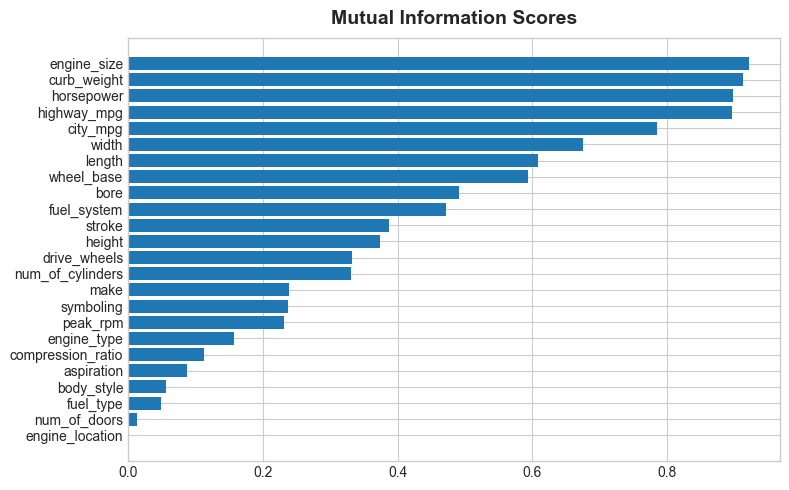

In [23]:
mi_scores = make_mi_scores(X, y, discrete_features)
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [24]:
# selected four features that cover a range of properties.
# Each of these features also has a high MI score with the target

features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [26]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


After fitting, the PCA instance contains the loadings in its components_ attribute. (Terminology for PCA is inconsistent, unfortunately. We're following the convention that calls the transformed columns in X_pca the components, which otherwise don't have a name.) We'll wrap the loadings up in a dataframe.


In [27]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


The first component (PC1) shows a contrast between large, powerful vehicles with poor gas milage, and smaller, more economical vehicles with good gas milage

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

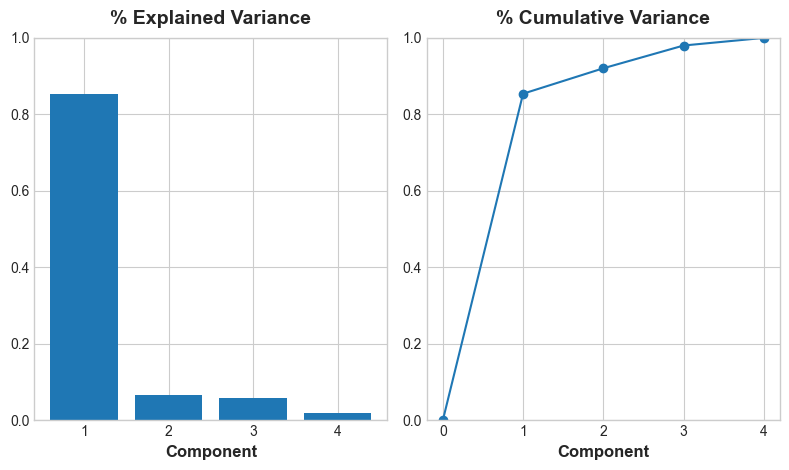

In [29]:
plot_variance(pca)

In [36]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.014400
PC2    0.379416
PC3    0.307302
PC4    0.204268
Name: MI Scores, dtype: float64

The third component shows a contrast between horsepower and curb_weight


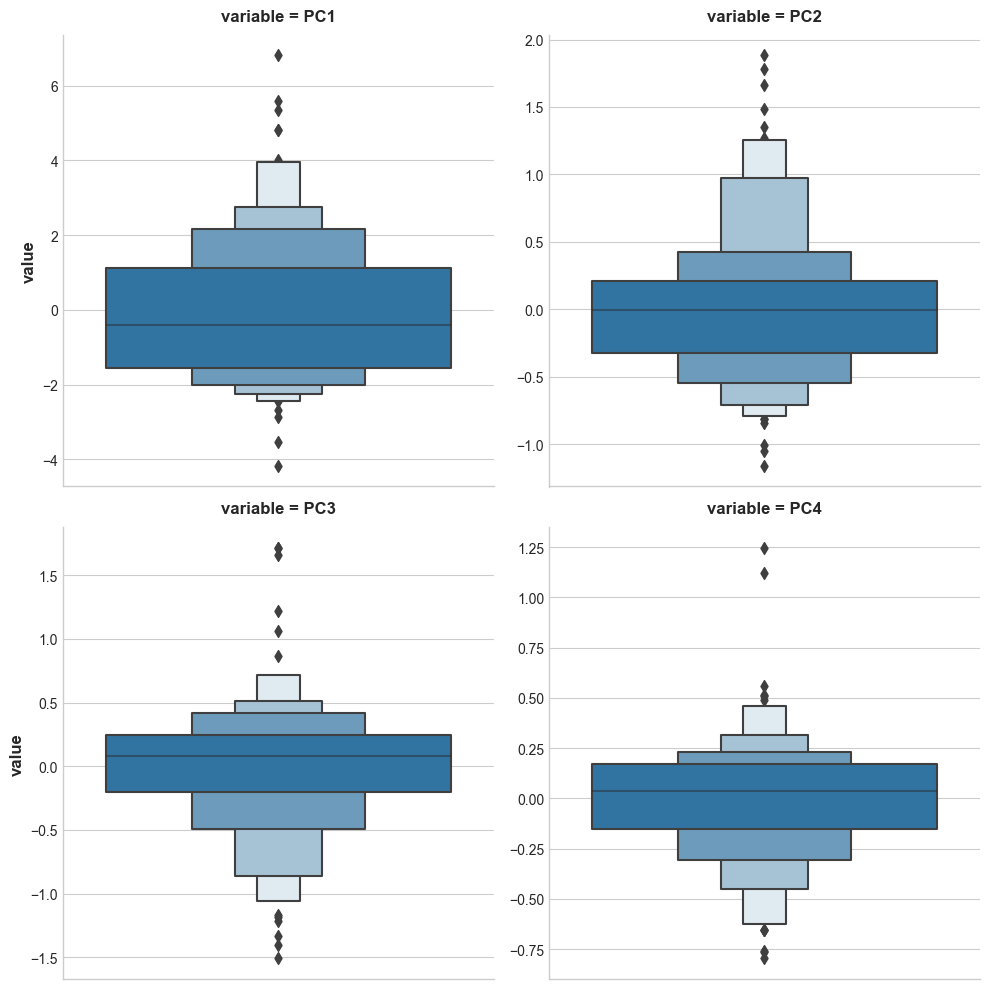

In [37]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
)

In [38]:
# Show dataframe sorted by PC3
idx = X_pca["PC4"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols]

,make,body_style,horsepower,curb_weight
65,mercedes-benz,hardtop,184,3715
64,mercedes-benz,sedan,184,3900
46,mazda,hatchback,68,1890
63,mercedes-benz,convertible,155,3685
127,subaru,hatchback,73,2120
...,...,...,...,...
66,mercury,hatchback,175,2910
186,volvo,sedan,162,3045
124,saab,hatchback,160,2808
187,volvo,wagon,162,3157


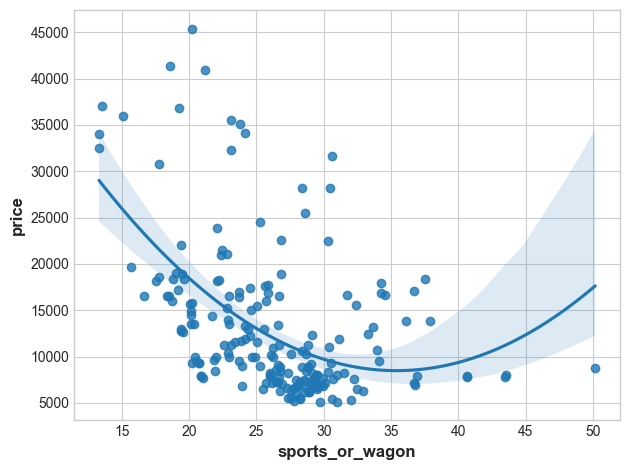

In [33]:
df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);